# COLETA DE DADOS

In [43]:
!pip install kagglehub
!pip install scipy

In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

import kagglehub
DATASET_PATH = os.environ.get("DATASET_PATH") or kagglehub.dataset_download(
    'hkayan/industrial-robotic-arm-imu-data-casper-1-and-2') + '/'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using Colab cache for faster access to the 'industrial-robotic-arm-imu-data-casper-1-and-2' dataset.
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_Acc_Gyro_20Hz.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_hitting_arm.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_20Hz_freq_drop_2.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_hitting_platform.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_10Hz.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/right_arm.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_2Hz.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/quaternions_no_idle.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_extra_weigth.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_20Hz_freq_drop.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/quaternions_20Hz.csv
/kaggle/

In [45]:
import re
normalPattern = "IMU_(.*)Hz.csv"

normal = ("IMU_10Hz.csv", ("label", 0))
faulty =("IMU_hitting_platform.csv", ("label", 1))

df = pd.read_csv(DATASET_PATH + normal[0])
df['label'] = 0

faultydf = pd.read_csv(DATASET_PATH+faulty[0])
faultydf['label'] = 1



In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. PREPARAÇÃO AUTOMÁTICA DOS DADOS
# ------------------------------------------------------------------------------
# Identificar colunas de sensores (removendo colunas de metadados)
cols_ignore = ['time', 'label', 'name', 'datetime', 'Unnamed: 0']
sensores = [c for c in df.columns if c not in cols_ignore]

print(f"Sensores detectados para análise: {sensores}")

# Criar o DataFrame unificado (Normal + Falha)
if 'df_total' not in locals():
    df_total = pd.concat([df, faultydf], ignore_index=True)
    print(f"Dataset combinado criado com sucesso: {df_total.shape}")
else:
    print("Dataset combinado 'df_total' já existente.")

Sensores detectados para análise: ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'magX', 'magY', 'magZ']
Dataset combinado 'df_total' já existente.



4. ANÁLISE BIVARIADA ESTRATÉGICA (SOMENTE VARIÁVEIS PADRÃO)


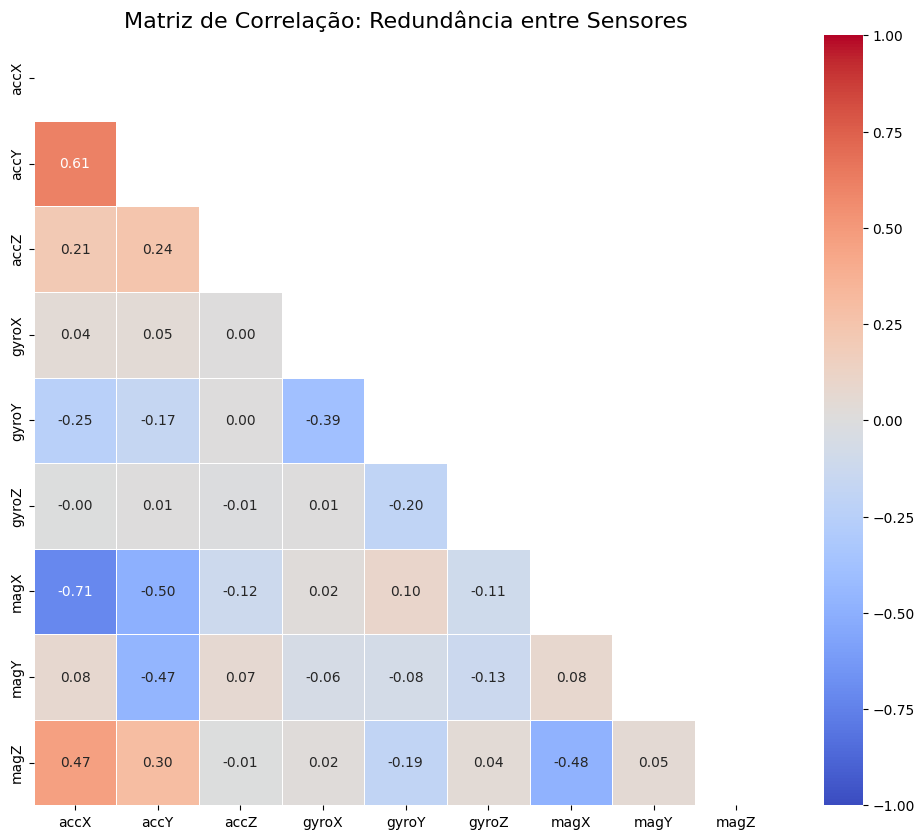


---> REDUNDÂNCIA #1 (Top 1 Feature-Feature)
     Par: accX vs magX (r=0.71)
     Motivo: O par de sensores brutos com maior vínculo físico.


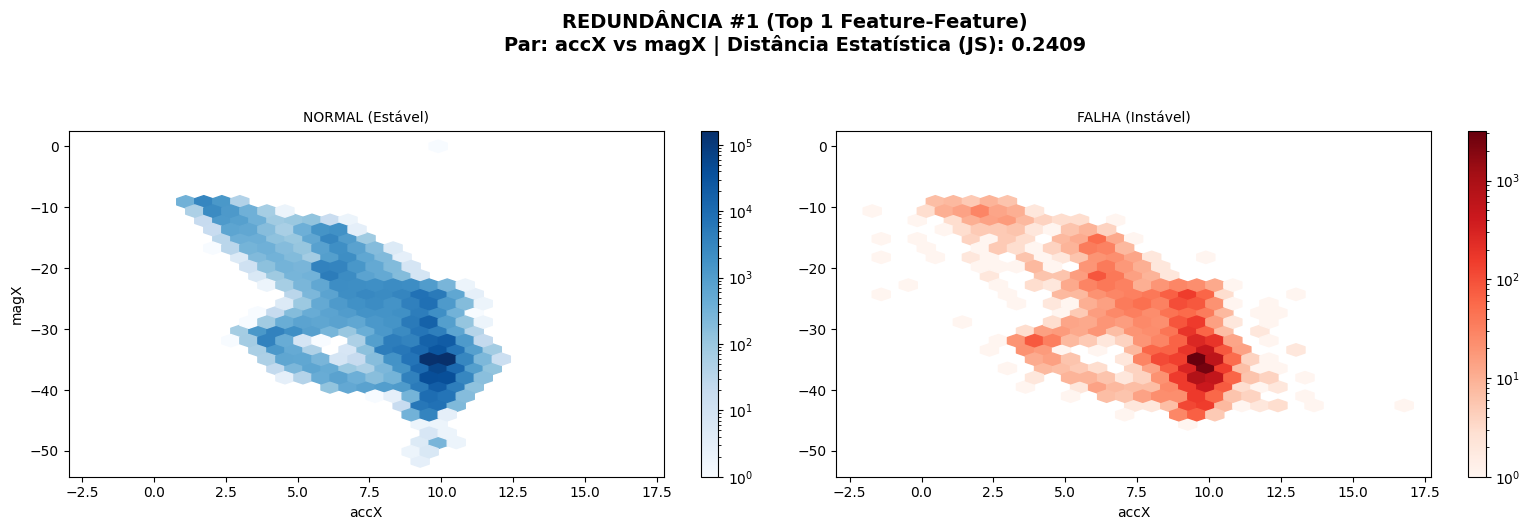


---> REDUNDÂNCIA #2 (Top 2 Feature-Feature)
     Par: accX vs accY (r=0.61)
     Motivo: Confirmação secundária de acoplamento mecânico.


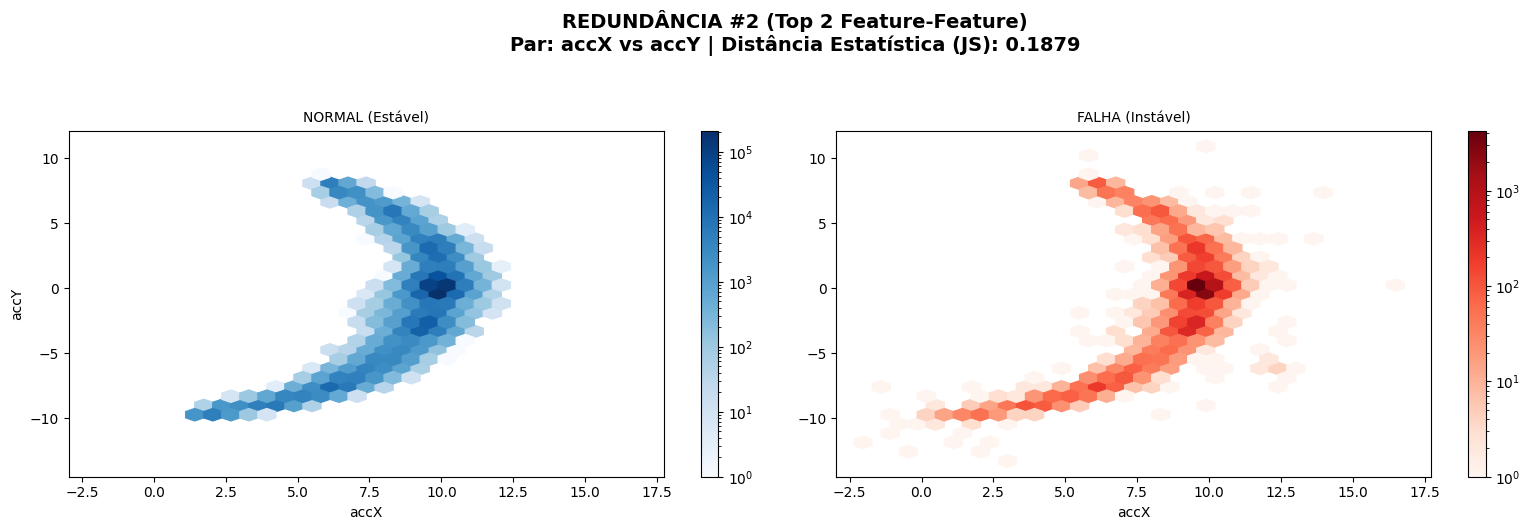


---> LINHA DE BASE (Média ~0.17)
     Par: accY vs gyroY (r=0.17)
     Motivo: Interação padrão entre eixos neste sistema.


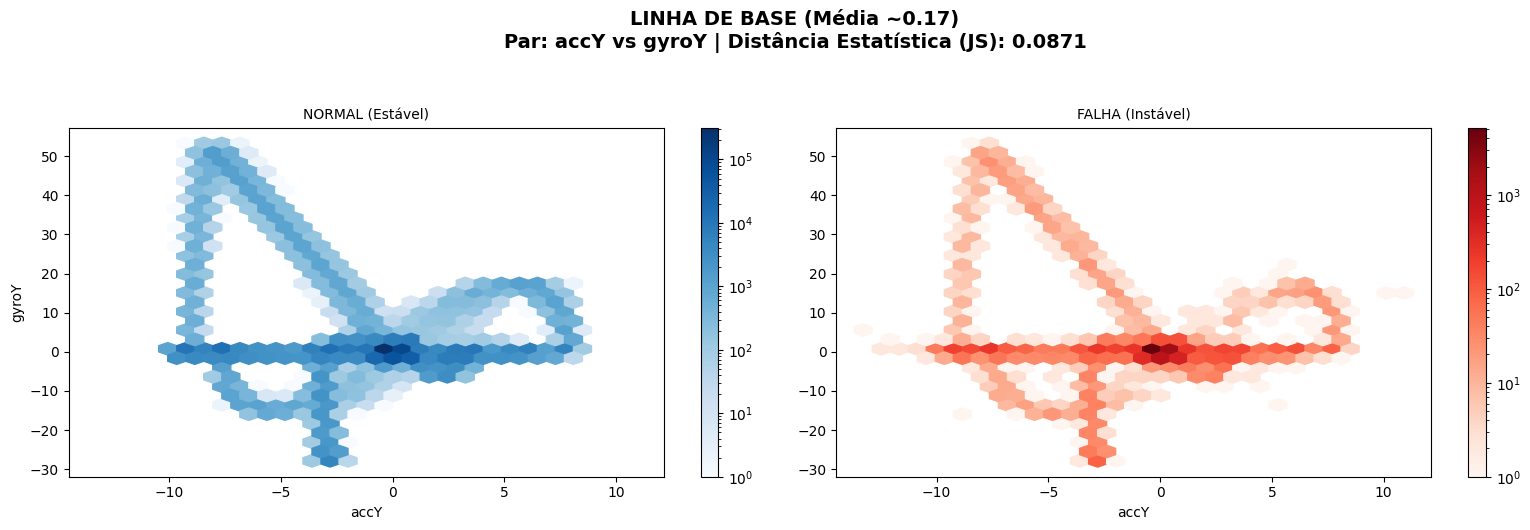


---> COMPLEMENTARIDADE (Informação Única)
     Par: accZ vs magZ (r=0.01)
     Motivo: Sensores importantes que "olham" aspectos diferentes da falha.


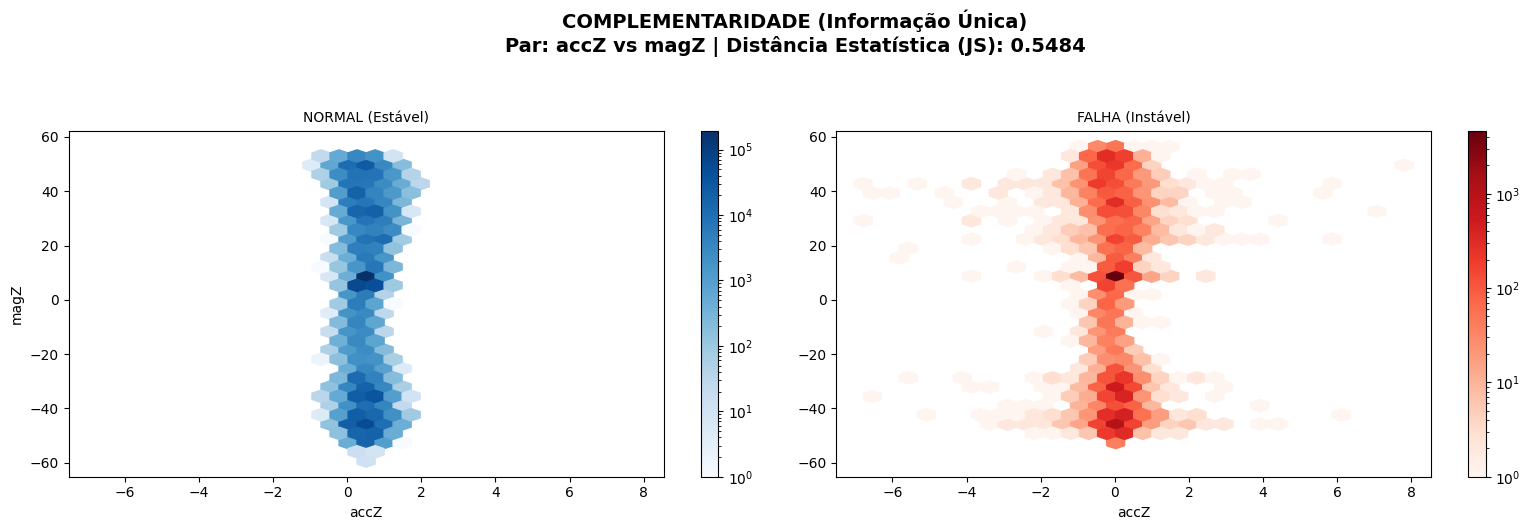


---> PODER PREDITIVO #1 (Top 1 vs Top 2)
     Par: accZ vs magX (r=0.12)
     Motivo: Os sensores campeões: accZ e magX.


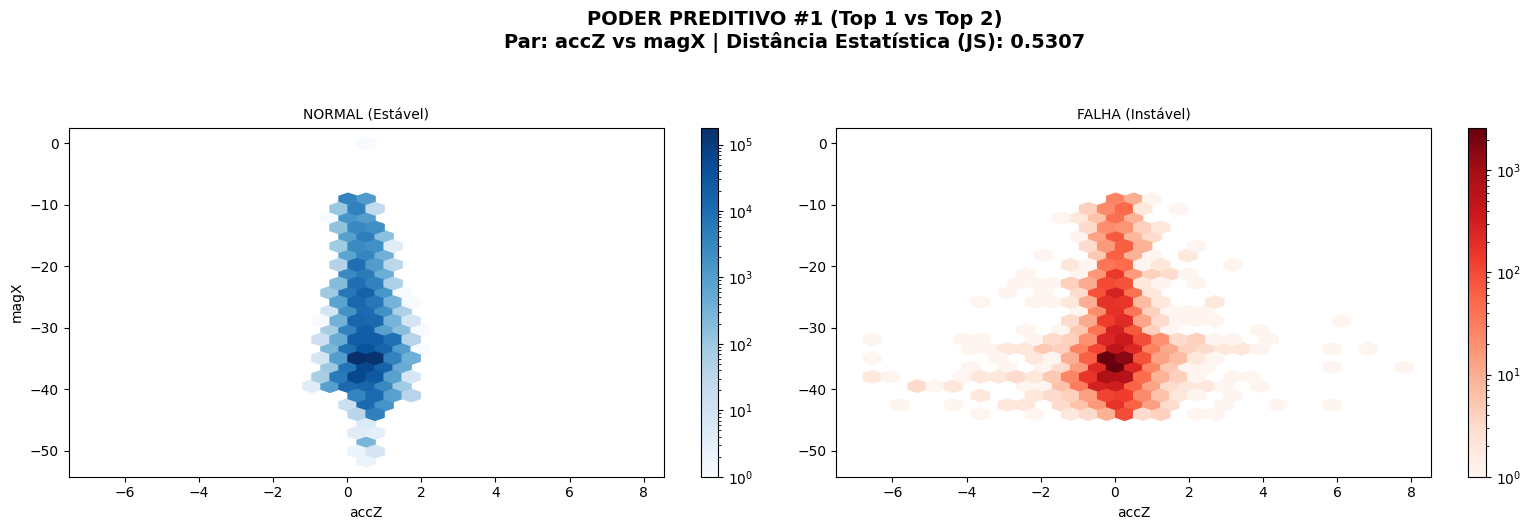


---> PODER PREDITIVO #2 (Top 3 vs Top 4)
     Par: magZ vs accX (r=0.47)
     Motivo: Sensores de suporte: magZ e accX.


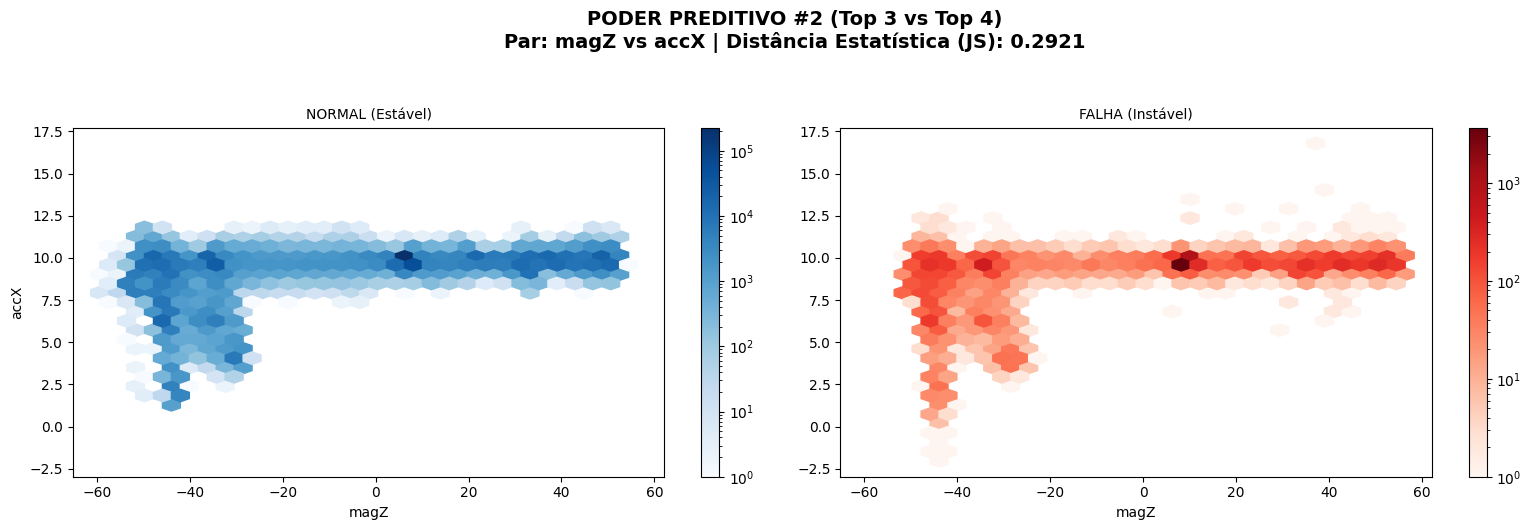

In [47]:
def analise_bivariada_estrategica_padrao(df_total):
    """
    Gera 6 cenários estratégicos para o relatório:
    1. REDUNDÂNCIA #1 (Maior Correlação Feature-Feature)
    2. REDUNDÂNCIA #2 (Segunda Maior Correlação - NOVO)
    3. MÉDIA (Correlação Típica/Mediana - NOVO)
    4. COMPLEMENTARIDADE (Baixa correlação entre features fortes)
    5. PREDITIVO #1 (Top 1 vs Top 2 Features com Label)
    6. PREDITIVO #2 (Top 3 vs Top 4 Features com Label - NOVO)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from scipy.spatial.distance import jensenshannon

    print("\n" + "="*80)
    print("4. ANÁLISE BIVARIADA ESTRATÉGICA (SOMENTE VARIÁVEIS PADRÃO)")
    print("="*80)

    # 1. DEFINIR APENAS OS SENSORES PADRÃO
    # Lista fixa dos 9 sensores possíveis
    lista_alvo = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'magX', 'magY', 'magZ']

    # Filtra para garantir que só usamos os que realmente existem no seu dataset
    sensores = [col for col in lista_alvo if col in df_total.columns]

    corr_m_1 = df_total[sensores].corr()
    plt.figure(figsize=(12, 10))
    # Máscara para esconder a metade repetida (triângulo superior)
    mask = np.triu(np.ones_like(corr_m_1, dtype=bool))

    sns.heatmap(corr_m_1, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
                vmin=-1, vmax=1, center=0, linewidths=0.5)

    plt.title('Matriz de Correlação: Redundância entre Sensores', fontsize=16)
    plt.show()

    # --- 2. CÁLCULO DAS MATRIZES ---
    # Matriz de correlação apenas entre os sensores padrão
    corr_matrix = df_total[sensores].corr().abs()

    # Correlação com o Label (Poder Preditivo)
    corr_with_label = df_total[sensores + ['label']].corr()['label'].drop('label').abs().sort_values(ascending=False)
    top_features_label = corr_with_label.index.tolist()

    # Preparar lista de pares ordenados por correlação entre si
    all_pairs = []
    cols = corr_matrix.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            all_pairs.append({
                'par': (cols[i], cols[j]),
                'val': corr_matrix.iloc[i, j]
            })
    sorted_pairs = sorted(all_pairs, key=lambda x: x['val'], reverse=True)

    # --- 3. SELEÇÃO DOS 6 CENÁRIOS (Lógica Pura) ---
    cenarios = []

    # A. REDUNDÂNCIA #1 (Maior Correlação)
    cenarios.append({
        'titulo': 'REDUNDÂNCIA #1 (Top 1 Feature-Feature)',
        'par': sorted_pairs[0]['par'],
        'val': sorted_pairs[0]['val'],
        'desc': 'O par de sensores brutos com maior vínculo físico.'
    })

    # B. REDUNDÂNCIA #2 (Segunda Maior)
    cenarios.append({
        'titulo': 'REDUNDÂNCIA #2 (Top 2 Feature-Feature)',
        'par': sorted_pairs[1]['par'],
        'val': sorted_pairs[1]['val'],
        'desc': 'Confirmação secundária de acoplamento mecânico.'
    })

    # C. MÉDIA (Correlação Típica)
    mean_corr = np.mean([p['val'] for p in all_pairs])
    par_medio = min(all_pairs, key=lambda x: abs(x['val'] - mean_corr))
    cenarios.append({
        'titulo': f'LINHA DE BASE (Média ~{mean_corr:.2f})',
        'par': par_medio['par'],
        'val': par_medio['val'],
        'desc': 'Interação padrão entre eixos neste sistema.'
    })

    # D. COMPLEMENTARIDADE (Baixa Correlação entre os Melhores)
    # Pega os Top 5 sensores que melhor predizem a falha
    top5 = top_features_label[:5]
    best_pair_comp = None
    min_corr = 1.0

    # Acha qual par dentro desses Top 5 tem a MENOR correlação entre si
    for i in range(len(top5)):
        for j in range(i+1, len(top5)):
            c = corr_matrix.loc[top5[i], top5[j]]
            if c < min_corr:
                min_corr = c
                best_pair_comp = (top5[i], top5[j])

    cenarios.append({
        'titulo': 'COMPLEMENTARIDADE (Informação Única)',
        'par': best_pair_comp,
        'val': min_corr,
        'desc': 'Sensores importantes que "olham" aspectos diferentes da falha.'
    })

    # E. PODER PREDITIVO #1 (Top 1 vs Top 2 Impacto no Label)
    cenarios.append({
        'titulo': 'PODER PREDITIVO #1 (Top 1 vs Top 2)',
        'par': (top_features_label[0], top_features_label[1]),
        'val': corr_matrix.loc[top_features_label[0], top_features_label[1]],
        'desc': f'Os sensores campeões: {top_features_label[0]} e {top_features_label[1]}.'
    })

    # F. PODER PREDITIVO #2 (Top 3 vs Top 4 Impacto no Label)
    cenarios.append({
        'titulo': 'PODER PREDITIVO #2 (Top 3 vs Top 4)',
        'par': (top_features_label[2], top_features_label[3]),
        'val': corr_matrix.loc[top_features_label[2], top_features_label[3]],
        'desc': f'Sensores de suporte: {top_features_label[2]} e {top_features_label[3]}.'
    })

    # --- 4. PLOTAGEM ---
    for item in cenarios:
        sensor_a, sensor_b = item['par']
        print(f"\n---> {item['titulo']}")
        print(f"     Par: {sensor_a} vs {sensor_b} (r={item['val']:.2f})")
        print(f"     Motivo: {item['desc']}")

        data_normal_x = df_total[df_total['label']==0][sensor_a]
        data_normal_y = df_total[df_total['label']==0][sensor_b]
        data_fail_x = df_total[df_total['label']==1][sensor_a]
        data_fail_y = df_total[df_total['label']==1][sensor_b]

        # Limites e Bins
        min_x, max_x = min(data_normal_x.min(), data_fail_x.min()), max(data_normal_x.max(), data_fail_x.max())
        min_y, max_y = min(data_normal_y.min(), data_fail_y.min()), max(data_normal_y.max(), data_fail_y.max())
        grid_extent = (min_x, max_x, min_y, max_y)
        bins = 30
        range_limits = [[min_x, max_x], [min_y, max_y]]

        # Cálculo JS Distance
        hist_normal, _, _ = np.histogram2d(data_normal_x, data_normal_y, bins=bins, range=range_limits, density=True)
        hist_fail, _, _ = np.histogram2d(data_fail_x, data_fail_y, bins=bins, range=range_limits, density=True)
        p, q = hist_normal.flatten(), hist_fail.flatten()
        p, q = np.where(p==0, 1e-10, p), np.where(q==0, 1e-10, q)
        js_dist = jensenshannon(p, q)

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))

        hb1 = axes[0].hexbin(data_normal_x, data_normal_y, gridsize=bins, cmap='Blues', bins='log', extent=grid_extent)
        axes[0].set_title(f'NORMAL (Estável)', fontsize=10)
        axes[0].set_xlabel(sensor_a); axes[0].set_ylabel(sensor_b)
        fig.colorbar(hb1, ax=axes[0])

        hb2 = axes[1].hexbin(data_fail_x, data_fail_y, gridsize=bins, cmap='Reds', bins='log', extent=grid_extent)
        axes[1].set_title(f'FALHA (Instável)', fontsize=10)
        axes[1].set_xlabel(sensor_a);
        fig.colorbar(hb2, ax=axes[1])

        plt.suptitle(f"{item['titulo']}\nPar: {sensor_a} vs {sensor_b} | Distância Estatística (JS): {js_dist:.4f}",
                     fontsize=14, fontweight='bold', y=1.05)
        plt.tight_layout()
        plt.show()

# EXECUÇÃO
analise_bivariada_estrategica_padrao(df_total)

In [48]:
def analise_multivariada_pca(df_total, sensores, target_col='label'):
    """
    Executa PCA e Gera Biplot (Pontos + Vetores de Carga) para visão global.
    """
    print("\n" + "="*80)
    print("5. ANÁLISE MULTIVARIADA (PCA + VETORES)")
    print("="*80)

    # 1. Padronização (Essencial para PCA)
    x = df_total[sensores].values
    x = StandardScaler().fit_transform(x)
    y = df_total[target_col].values

    # 2. Calcular PCA (2 Componentes)
    pca = PCA(n_components=2)
    components = pca.fit_transform(x)

    pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
    pca_df['Target'] = y

    # Cargas (Loadings) - Importância dos sensores
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    # 3. Plotagem Biplot
    plt.figure(figsize=(14, 12))

    # A. Pontos (Scatter)
    idx_sample = np.random.choice(len(pca_df), size=min(3000, len(pca_df)), replace=False)
    sample = pca_df.iloc[idx_sample]

    sns.scatterplot(x='PC1', y='PC2', hue='Target', data=sample,
                    palette={0: '#1f77b4', 1: '#d62728'}, alpha=0.5, s=70)

    # B. Vetores (Setas indicando os sensores)
    scale_factor = 4.0 # Ajuste visual para as setas aparecerem bem

    for i, sensor in enumerate(sensores):
        plt.arrow(0, 0, loadings[i, 0] * scale_factor, loadings[i, 1] * scale_factor,
                  color='black', alpha=0.8, head_width=0.08, linewidth=1.5)

        plt.text(loadings[i, 0] * scale_factor * 1.15, loadings[i, 1] * scale_factor * 1.15,
                 sensor, color='black', ha='center', va='center', fontweight='bold', fontsize=11)

    var_total = pca.explained_variance_ratio_.sum() * 100
    plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.2%} Var)')
    plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.2%} Var)')
    plt.title(f'PCA Biplot: Separação de Classes (Explica {var_total:.1f}% da Variância)', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Classe (0=Normal, 1=Falha)', loc='upper right')
    plt.show()

    print("-> Setas: Indicam quais sensores 'puxam' os dados para aquela direção.")
    print("-> Pontos Vermelhos Separados: O modelo terá facilidade em classificar.")


5. ANÁLISE MULTIVARIADA (PCA + VETORES)


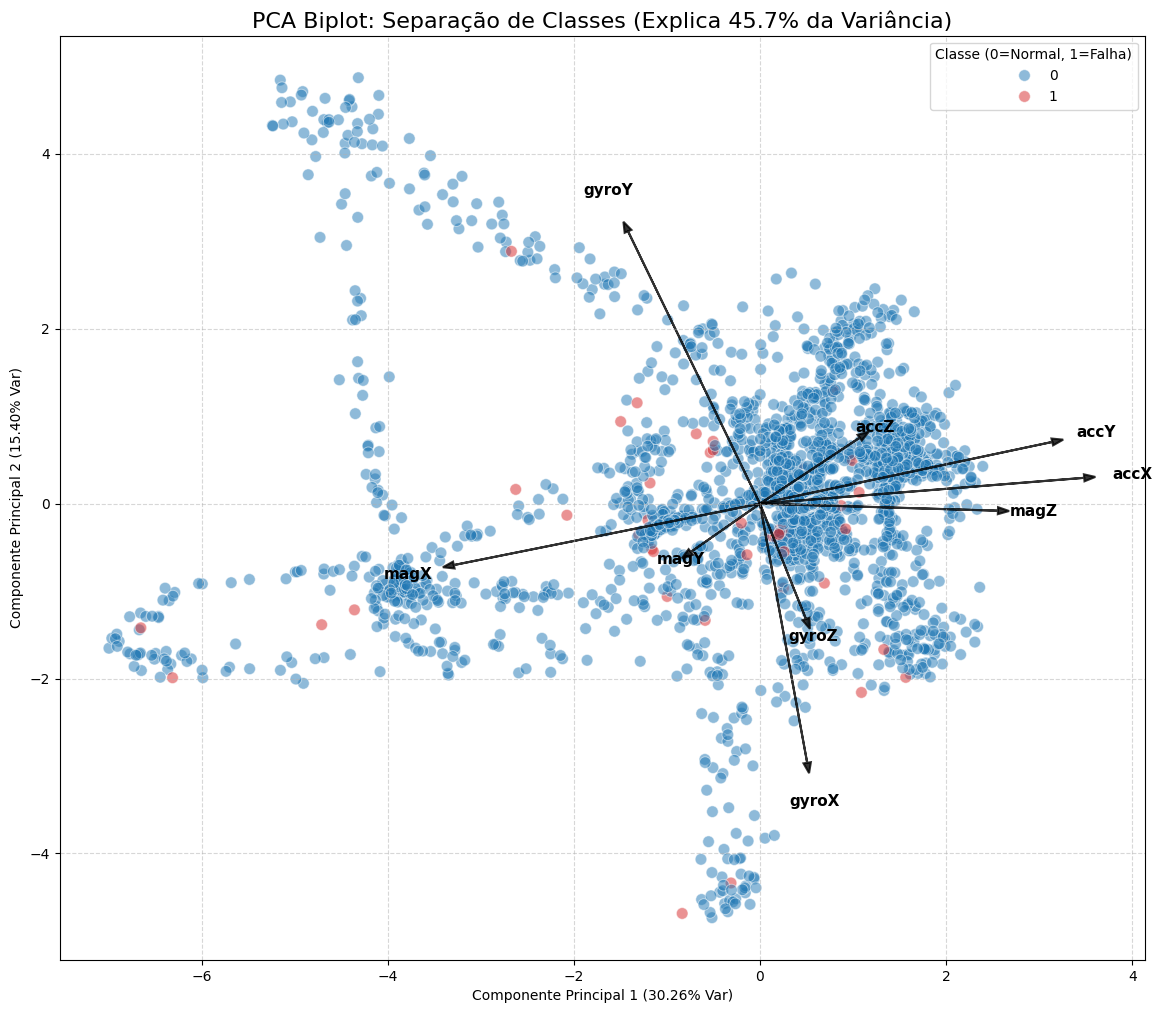

-> Setas: Indicam quais sensores 'puxam' os dados para aquela direção.
-> Pontos Vermelhos Separados: O modelo terá facilidade em classificar.


In [49]:
analise_multivariada_pca(df_total, sensores)


ANÁLISE DE TRAJETÓRIA TEMPORAL (JANELA DE 10s)


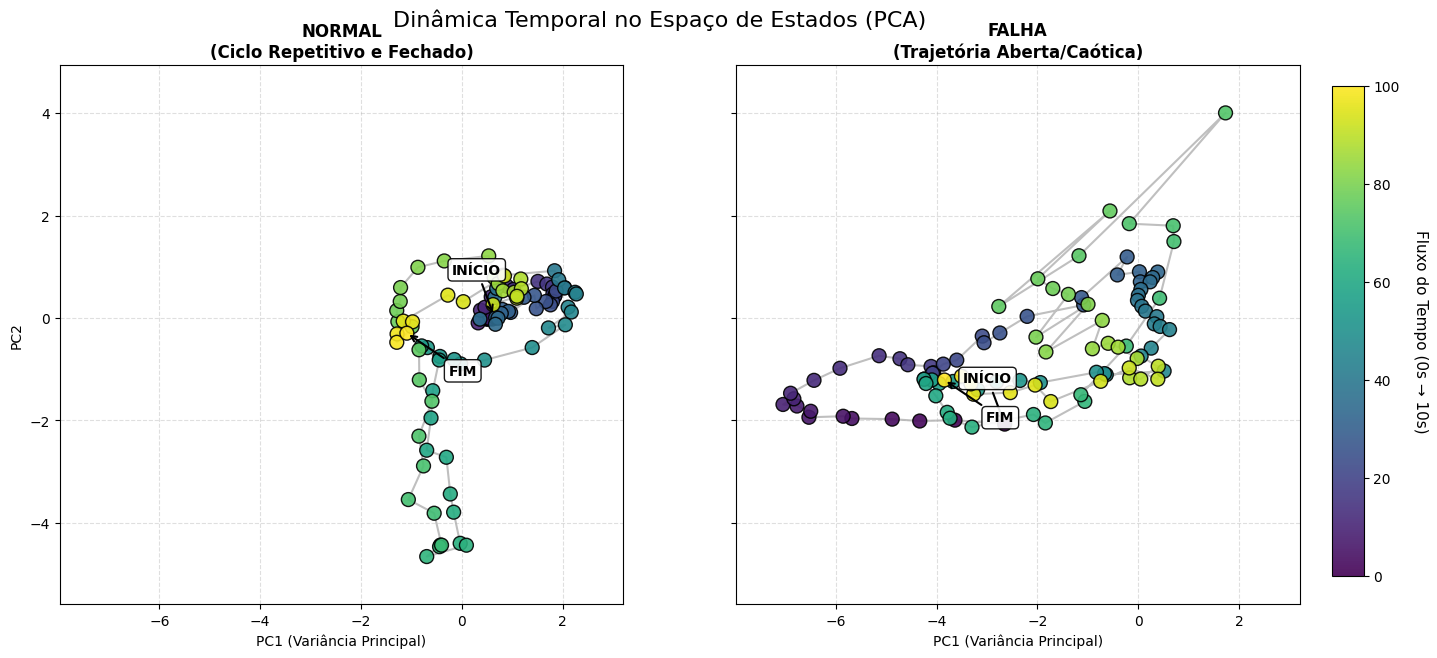

In [50]:
def analise_pca_temporal_trajetoria(df_total, sensores, janela_segundos=10, freq_hz=10):
    """
    Gera apenas a Análise de Trajetória Temporal no Espaço PCA.
    Mostra a evolução do movimento (Início -> Fim) para comparar Estabilidade vs Caos.
    """
    print("\n" + "="*80)
    print(f"ANÁLISE DE TRAJETÓRIA TEMPORAL (JANELA DE {janela_segundos}s)")
    print("="*80)

    # 1. CÁLCULO DO PCA (Necessário para gerar as coordenadas PC1/PC2)
    # Padronizar
    X = df_total[sensores]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(X_scaled)

    # DataFrame Temporário
    df_pca = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
    df_pca['label'] = df_total['label'].values

    # 2. SELEÇÃO DA JANELA TEMPORAL
    pontos = janela_segundos * freq_hz

    # Selecionar trecho NORMAL (meio do dataset)
    idx_n = df_pca[df_pca['label']==0].index
    start_n = idx_n[len(idx_n)//2]
    traj_norm = df_pca.loc[start_n : start_n + pontos].reset_index(drop=True)

    # Selecionar trecho FALHA (meio do dataset)
    idx_f = df_pca[df_pca['label']==1].index
    start_f = idx_f[len(idx_f)//2]
    traj_fail = df_pca.loc[start_f : start_f + pontos].reset_index(drop=True)

    # 3. PLOTAGEM
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True, sharex=True)

    # Definir limites globais para comparação justa (zoom automático na área de interesse)
    all_x = pd.concat([traj_norm['PC1'], traj_fail['PC1']])
    all_y = pd.concat([traj_norm['PC2'], traj_fail['PC2']])
    margin = (all_x.max() - all_x.min()) * 0.1
    axes[0].set_xlim(all_x.min()-margin, all_x.max()+margin)
    axes[0].set_ylim(all_y.min()-margin, all_y.max()+margin)

    # Função interna de desenho
    def desenhar_trajetoria(ax, dados, titulo):
        # Scatter colorido pelo tempo (índice)
        sc = ax.scatter(dados['PC1'], dados['PC2'], c=np.arange(len(dados)),
                        cmap='viridis', s=100, edgecolor='k', alpha=0.9, zorder=2)
        # Linha conectora (Rastro)
        ax.plot(dados['PC1'], dados['PC2'], c='gray', lw=1.5, alpha=0.5, zorder=1)

        # Anotações (Início/Fim) com setas
        # INÍCIO
        ax.annotate('INÍCIO', xy=(dados.iloc[0]['PC1'], dados.iloc[0]['PC2']),
                    xytext=(-30, 30), textcoords='offset points',
                    arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
                    fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.9))

        # FIM
        ax.annotate('FIM', xy=(dados.iloc[-1]['PC1'], dados.iloc[-1]['PC2']),
                    xytext=(30, -30), textcoords='offset points',
                    arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
                    fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.9))

        ax.set_title(titulo, fontsize=12, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.set_xlabel("PC1 (Variância Principal)")
        return sc

    # Plotar os dois lados
    sc = desenhar_trajetoria(axes[0], traj_norm, f"NORMAL\n(Ciclo Repetitivo e Fechado)")
    desenhar_trajetoria(axes[1], traj_fail, f"FALHA\n(Trajetória Aberta/Caótica)")

    axes[0].set_ylabel("PC2")

    # Barra de Cores Lateral
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # Posição manual [left, bottom, width, height]
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label(f'Fluxo do Tempo (0s \u2192 {janela_segundos}s)', fontsize=11, rotation=270, labelpad=20)

    plt.suptitle("Dinâmica Temporal no Espaço de Estados (PCA)", fontsize=16, y=0.96)
    plt.show()

# EXECUÇÃO
analise_pca_temporal_trajetoria(df_total, sensores, janela_segundos=10)


CRIAÇÃO DE VARIÁVEIS DERIVADAS E GRUPOS DE INTERESSE
Calculando Magnitudes (Aceleração, Giroscópio e Magnetômetro)...


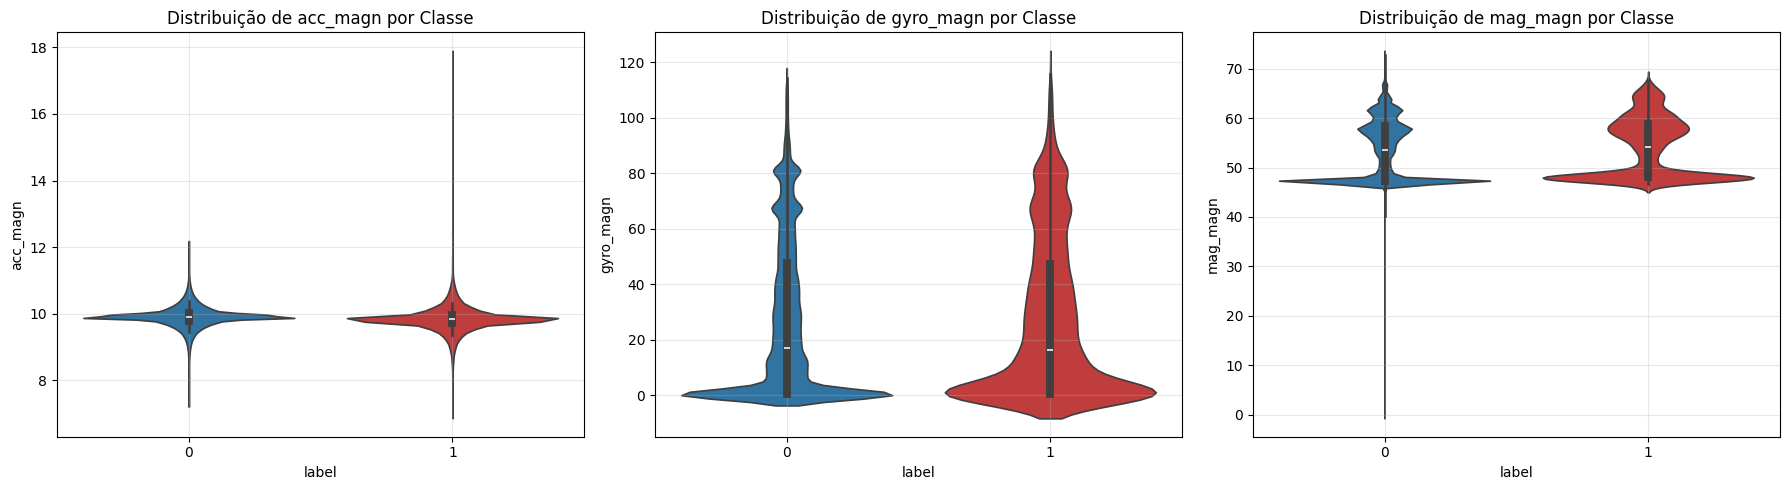


Executando K-Means para encontrar Grupos de Interesse...


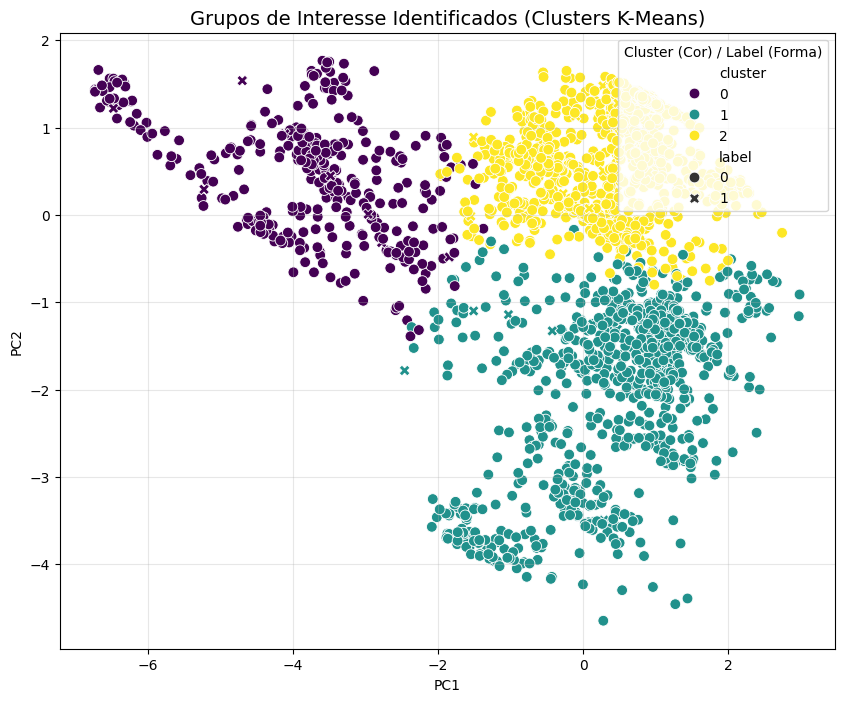


[INSIGHT] Distribuição de Falhas por Grupo Identificado:
label    Normal (%)  Falha (%)
cluster                       
0         98.185720   1.814280
1         98.294967   1.705033
2         98.358418   1.641582
--------------------------------------------------
-> ANÁLISE: Nenhum grupo se mostrou estatisticamente relevante.
-> O maior cluster (0) tem 1.81% de falhas, praticamente igual à média global (1.68%).
-> Isso indica que este método de agrupamento não conseguiu isolar a anomalia.


In [51]:
# ==============================================================================
# VARIÁVEIS DERIVADAS E ANÁLISE DE GRUPOS
# ==============================================================================
from sklearn.cluster import KMeans

def feature_engineering_e_cluster(df_total, sensores):
    print("\n" + "="*80)
    print("CRIAÇÃO DE VARIÁVEIS DERIVADAS E GRUPOS DE INTERESSE")
    print("="*80)

    # --- 1. CRIAÇÃO DE VARIÁVEIS DERIVADAS (Magnitude Física) ---
    print("Calculando Magnitudes (Aceleração, Giroscópio e Magnetômetro)...")

    # Magnitude da Aceleração
    df_total['acc_magn'] = np.sqrt(df_total['accX']**2 + df_total['accY']**2 + df_total['accZ']**2)

    # Magnitude do Giroscópio
    df_total['gyro_magn'] = np.sqrt(df_total['gyroX']**2 + df_total['gyroY']**2 + df_total['gyroZ']**2)

    df_total['mag_magn'] = np.sqrt(df_total['magX']**2 + df_total['magY']**2 + df_total['magZ']**2)

    novas_features = ['acc_magn', 'gyro_magn', 'mag_magn']
    n_plots = 3
    fig_width = 18

    # Visualizar (Violin Plot)
    plt.figure(figsize=(fig_width, 5))

    for i, feat in enumerate(novas_features):
        plt.subplot(1, n_plots, i+1)

        # Sintaxe atualizada para evitar warnings
        sns.violinplot(data=df_total, x='label', y=feat, hue='label',
                       palette={0: '#1f77b4', 1: '#d62728'}, legend=False)

        plt.title(f'Distribuição de {feat} por Classe')
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 2. ANÁLISE DE GRUPOS DE INTERESSE (CLUSTERING) ---
    print("\nExecutando K-Means para encontrar Grupos de Interesse...")

    features_cluster = sensores + novas_features

    # Padronizar
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_total[features_cluster])

    # Criar 3 Clusters
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df_total['cluster'] = kmeans.fit_predict(X_scaled)

    # Visualizar Clusters no Espaço PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(X_scaled)
    df_total['PC1'] = pca_coords[:, 0]
    df_total['PC2'] = pca_coords[:, 1]

    plt.figure(figsize=(10, 8))
    # Usamos style='label' para diferenciar visualmente quem é normal/falha dentro do cluster
    sns.scatterplot(data=df_total.sample(min(3000, len(df_total)), random_state=42),
                    x='PC1', y='PC2', hue='cluster', palette='viridis',
                    style='label', s=60)
    plt.title('Grupos de Interesse Identificados (Clusters K-Means)', fontsize=14)
    plt.legend(title='Cluster (Cor) / Label (Forma)', loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- 3. ANÁLISE CRUZADA: CLUSTER vs FALHA ---
    tabela_grupos = pd.crosstab(df_total['cluster'], df_total['label'], normalize='index') * 100
    print("\n[INSIGHT] Distribuição de Falhas por Grupo Identificado:")
    print(tabela_grupos.rename(columns={0: 'Normal (%)', 1: 'Falha (%)'}))
    print("-" * 50)

    taxa_global = df_total['label'].mean() * 100

    # Pega o pior grupo
    grupo_risco = tabela_grupos[1].idxmax()
    risco_val = tabela_grupos.loc[grupo_risco, 1]

    # Define um limiar de relevância: O grupo tem que ser pelo menos 30% pior que a média global
    # Ex: Se média é 1.7%, o grupo tem que ter > 2.2% para ser "Interessante"
    limiar_relevancia = taxa_global * 1.3

    if risco_val > limiar_relevancia:
        print(f"-> O Grupo {grupo_risco} DESTACA-SE como 'Grupo de Interesse'.")
        print(f"-> Ele concentra {risco_val:.2f}% de falhas (Média Global: {taxa_global:.2f}%).")
    else:
        print(f"-> ANÁLISE: Nenhum grupo se mostrou estatisticamente relevante.")
        print(f"-> O maior cluster ({grupo_risco}) tem {risco_val:.2f}% de falhas, praticamente igual à média global ({taxa_global:.2f}%).")
        print(f"-> Isso indica que este método de agrupamento não conseguiu isolar a anomalia.")

# EXECUÇÃO
feature_engineering_e_cluster(df_total, sensores)

In [52]:
def gerar_tabela_ranking_ks(df_total, lista_sensores):
    """
    Gera uma tabela formatada de ranking de importância baseada no teste KS,
    Ratio de Variância e Diferença de Médias.
    """
    import pandas as pd
    import numpy as np
    from scipy.stats import ks_2samp

    resultados = []

    for sensor in lista_sensores:
        # Garante que o sensor existe no dataframe
        if sensor not in df_total.columns:
            continue

        # Separa os dados (Limpando NaNs para evitar erros)
        data_normal = df_total[df_total['label'] == 0][sensor].dropna()
        data_falha = df_total[df_total['label'] == 1][sensor].dropna()

        # 1. KS Statistic (Poder de Separação)
        # Retorna a estatística KS (distância máxima entre as curvas acumuladas)
        ks_stat, _ = ks_2samp(data_normal, data_falha)

        # 2. Variance Ratio (Sensibilidade à Vibração)
        var_norm = np.var(data_normal)
        var_fail = np.var(data_falha)
        # Evita divisão por zero
        if var_norm == 0: var_norm = 1e-9
        var_ratio = var_fail / var_norm

        # 3. Mean Difference (Mudança de Ponto de Operação)
        mean_diff = abs(np.mean(data_falha) - np.mean(data_normal))

        resultados.append({
            'Sensor': sensor,
            'KS_Statistic': ks_stat,
            'Variance_Ratio': var_ratio,
            'Mean_Diff': mean_diff
        })

    # Cria o DataFrame e ordena pelo KS
    df_rank = pd.DataFrame(resultados)
    df_rank = df_rank.sort_values(by='KS_Statistic', ascending=False).reset_index(drop=True)

    # --- EXIBIÇÃO FORMATADA IGUAL AO SEU PEDIDO ---
    print("="*60)
    print("RANKING DE IMPORTÂNCIA DOS SENSORES (Baseado em KS-Test)")
    print("="*60)
    print("KS_Statistic: 1.0 = Separação Perfeita | 0.0 = Indistinguível")
    print("Variance_Ratio: > 1.0 = Falha aumentou a variabilidade")
    print("-" * 60)

    # Imprime a tabela alinhada
    print(df_rank.to_string(index=True, float_format="%.6f"))

    return df_rank

# EXECUÇÃO
# Reúna todas as variáveis que você quer testar (Sensores Originais + Magnitudes criadas)
variaveis_para_teste = sensores + ['acc_magn', 'gyro_magn','mag_magn'] # Adicione outras se tiver (ex: mag_magn)

# Filtra apenas as que existem no seu DF para não dar erro
variaveis_existentes = [v for v in variaveis_para_teste if v in df_total.columns]

tabela = gerar_tabela_ranking_ks(df_total, variaveis_existentes)

RANKING DE IMPORTÂNCIA DOS SENSORES (Baseado em KS-Test)
KS_Statistic: 1.0 = Separação Perfeita | 0.0 = Indistinguível
Variance_Ratio: > 1.0 = Falha aumentou a variabilidade
------------------------------------------------------------
       Sensor  KS_Statistic  Variance_Ratio  Mean_Diff
0        accZ      0.714782        3.413186   0.477112
1    mag_magn      0.306920        1.009540   0.577851
2        magZ      0.290843        1.022190   1.959185
3    acc_magn      0.280889        1.614106   0.065857
4        accX      0.237591        1.032784   0.069701
5        magY      0.151337        1.001709   0.356295
6        magX      0.145662        0.950681   0.496916
7       gyroX      0.063579        1.000485   0.046277
8       gyroY      0.056396        0.973587   0.001831
9       gyroZ      0.032928        0.996954   0.016725
10  gyro_magn      0.026400        1.003267   0.114199
11       accY      0.020974        1.010212   0.009628



ROUND 1: QUEM É O MELHOR SENSOR PURO? (Apenas os 9 eixos)


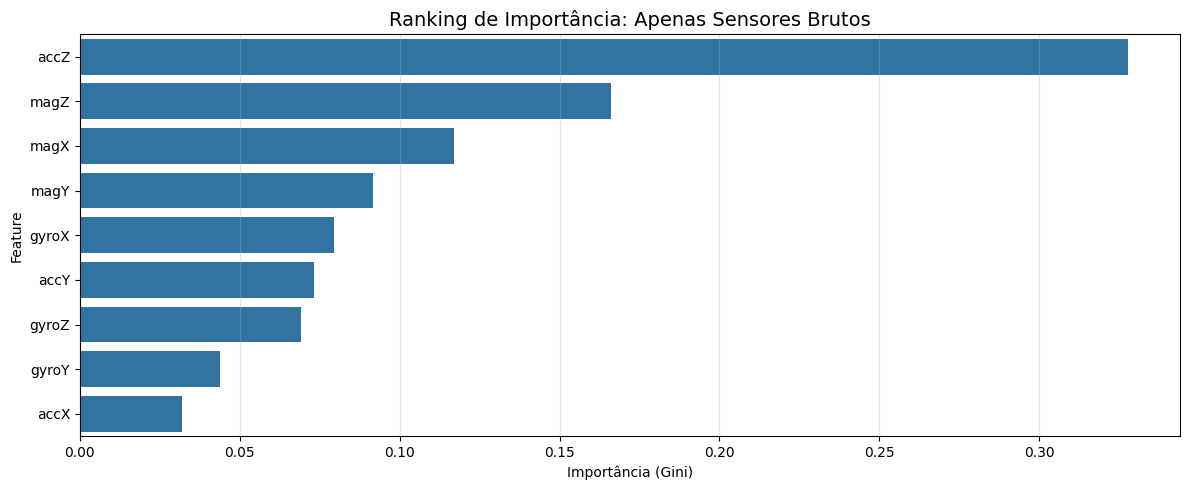


ROUND 2: DUELO GERAL (Sensores Brutos vs Variáveis Criadas)


/tmp/ipython-input-2352386230.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Feature', data=imp_full, palette=cores, alpha=0.8)


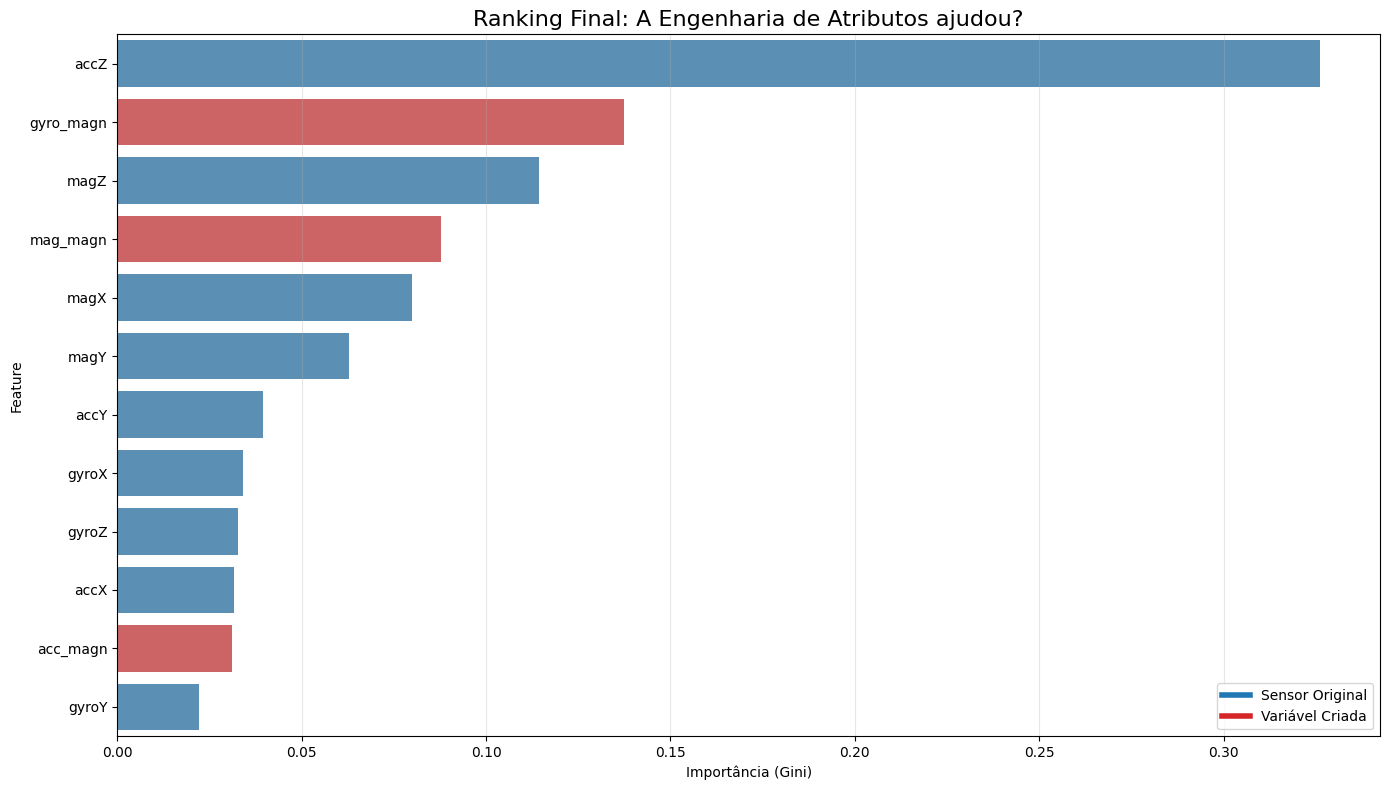

In [53]:
def ranking_de_importancia(df_total, sensores_originais):
    """
    Executa duas análises de importância via Random Forest:
    1. Apenas com os Sensores Originais (Quem é o melhor sensor físico?).
    2. Com Todas as Variáveis (A engenharia de atributos superou o dado bruto?).
    """
    from sklearn.ensemble import RandomForestClassifier

    # --- PREPARAÇÃO DE DADOS (Feito uma vez só para economizar RAM) ---
    # Usamos uma amostra de 20k linhas
    if len(df_total) > 20000:
        df_sample = df_total.sample(20000, random_state=42)
    else:
        df_sample = df_total.copy()

    y = df_sample['label']

    # Identificar variáveis derivadas
    palavras_chave = ['magn', 'std', 'mean', 'jerk', 'mad', 'energy', 'kurtosis']
    features_extras = [col for col in df_total.columns if any(p in col for p in palavras_chave)]
    # Garante que são numéricas
    features_extras = [f for f in features_extras if f in df_total.columns and df_total[f].dtype in [np.float64, np.float32, np.int64]]

    # ==========================================================================
    # ROUND 1: APENAS SENSORES ORIGINAIS (RAW DATA)
    # ==========================================================================
    print("\n" + "="*80)
    print("ROUND 1: QUEM É O MELHOR SENSOR PURO? (Apenas os 9 eixos)")
    print("="*80)

    # Filtra apenas colunas que existem no DF
    sensores_existentes = [s for s in sensores_originais if s in df_total.columns]

    model_raw = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
    model_raw.fit(df_sample[sensores_existentes], y)

    imp_raw = pd.DataFrame({
        'Feature': sensores_existentes,
        'Importancia': model_raw.feature_importances_
    }).sort_values('Importancia', ascending=False)

    # Plot Round 1
    plt.figure(figsize=(12, 5))
    sns.barplot(x='Importancia', y='Feature', data=imp_raw, color='#1f77b4') # Tudo Azul
    plt.title('Ranking de Importância: Apenas Sensores Brutos', fontsize=14)
    plt.xlabel('Importância (Gini)')
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ==========================================================================
    # ROUND 2: DUELO COMPLETO (ORIGINAIS vs DERIVADAS)
    # ==========================================================================
    print("\n" + "="*80)
    print("ROUND 2: DUELO GERAL (Sensores Brutos vs Variáveis Criadas)")
    print("="*80)

    features_finais = list(set(sensores_existentes + features_extras))

    model_full = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
    model_full.fit(df_sample[features_finais], y)

    imp_full = pd.DataFrame({
        'Feature': features_finais,
        'Importancia': model_full.feature_importances_
    }).sort_values('Importancia', ascending=False)

    # Plot Round 2
    plt.figure(figsize=(14, 8))
    # Cores: Azul (Original) vs Vermelho (Criada)
    cores = ['#1f77b4' if f in sensores_originais else '#d62728' for f in imp_full['Feature']]

    sns.barplot(x='Importancia', y='Feature', data=imp_full, palette=cores, alpha=0.8)

    # Legenda
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#1f77b4', lw=4, label='Sensor Original'),
        Line2D([0], [0], color='#d62728', lw=4, label='Variável Criada')
    ]
    plt.legend(handles=legend_elements, loc='lower right')

    plt.title('Ranking Final: A Engenharia de Atributos ajudou?', fontsize=16)
    plt.xlabel('Importância (Gini)')
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# EXECUÇÃO
ranking_de_importancia(df_total, sensores)